# P-Tuning
***No GPU is required for this task.***

**P-tuning** (prompt tuning) is a parameter-efficient method for adapting pre-trained or base models to downstream tasks. In this notebook, we:
1. **Train a base model** on the task with all parameters trainable (Phase 1).
2. **Freeze the base model** and prepend **learnable prompt embeddings** to the input (Phase 2). Only the prompt parameters (and optionally a small MLP reparameterization) are trained. This is done instead of fine-tuning all model weights. For simplicity we use the same dataset.

In this task you work with a small **transformer encoder** (with Rotary Position Embeddings, RoPE) on the **AG News** dataset (4-class text classification: World, Sports, Business, Sci/Tech). The pipeline:

- **Phase 1:** Train `StandardTuningModel` (full training) on a subset of AG News.
- **Phase 2:** Freeze that model, add p-tuning (learnable prompts + MLP) via `PromptTuningModel`, and train only the prompt-related parameters.

You will compare **validation/test accuracy** and the **number of trainable parameters** between the base model and the p-tuning model, and plot training/validation loss and accuracy for both phases.

## Task outline
* Fill the missing parts of code (do not modify other parts):
  * PromptTuningModel.forward
  * PromptTuningModel.get_trainable_parameters
  * freeze_model_weights
  * count_trainable_and_frozen_params
  * create_ptuning_model
* Run the experiment
* Comment the result. Do you see any application of the experiment result?


In [138]:
!tar -xf data.tar.gz
%set_env HF_HUB_OFFLINE=1
%set_env HF_HOME=./hf_cache

env: HF_HUB_OFFLINE=1
env: HF_HOME=./hf_cache


In [139]:
import math
import pickle
from typing import cast

import matplotlib.pyplot as plt
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Model components: RoPE and Transformer encoder

In [140]:
class RoPE(nn.Module):
    """Rotary Position Embedding (RoPE)."""

    def __init__(self, dim: int, max_seq_len: int = 2048, base: int = 10000) -> None:
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base

        self.inv_freq: Tensor
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, x: Tensor, seq_len: int | None = None) -> Tensor:
        if seq_len is None:
            seq_len = x.shape[1]

        t = torch.arange(seq_len, device=x.device, dtype=x.dtype)
        freqs = torch.outer(t, self.inv_freq)
        freqs = torch.cat([freqs, freqs], dim=-1)
        cos = freqs.cos()
        sin = freqs.sin()

        cos = cos.unsqueeze(0).unsqueeze(2)
        sin = sin.unsqueeze(0).unsqueeze(2)

        x1 = x[..., : self.dim // 2]
        x2 = x[..., self.dim // 2 :]

        x_rotated = torch.cat([-x2, x1], dim=-1)

        return x * cos + x_rotated * sin


class RoPEMultiHeadAttention(nn.Module):
    """Multi-head attention with RoPE applied to queries and keys."""

    def __init__(self, embed_dim: int, num_heads: int):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim % 2 == 0, "head_dim must be even for RoPE"

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

        self.rope = RoPE(self.head_dim)

        self.scale = 1.0 / math.sqrt(self.head_dim)

    def forward(self, x: Tensor, mask: Tensor | None = None) -> Tensor:
        batch_size, seq_len, _ = x.shape

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        q = self.rope(q, seq_len)
        k = self.rope(k, seq_len)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = torch.softmax(scores, dim=-1)

        attn_output = torch.matmul(attn_weights, v)

        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, seq_len, self.embed_dim)

        output = self.out_proj(attn_output)

        return output


class RoPETransformerEncoderLayer(nn.Module):
    """Transformer encoder layer with RoPE-based attention."""

    def __init__(
        self,
        d_model: int,
        nhead: int,
        dim_feedforward: int,
    ) -> None:
        super().__init__()
        self.self_attn = RoPEMultiHeadAttention(d_model, nhead)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.RMSNorm(d_model)
        self.norm2 = nn.RMSNorm(d_model)

    def forward(self, x: Tensor, mask: Tensor | None = None) -> Tensor:
        x_attn = self.self_attn(x, mask)
        x = self.norm1(x + x_attn)

        x_ffn = self.linear2(torch.relu(self.linear1(x)))
        x = self.norm2(x + x_ffn)

        return x

## Standard tuning model (full training)

In [141]:
class StandardTuningModel(nn.Module):
    """Small transformer model for text classification."""

    def __init__(
        self,
        vocab_size: int,
        num_classes: int = 4,
        embed_dim: int = 64,
        num_heads: int = 2,
        num_layers: int = 1,
        max_seq_length: int = 128,
    ) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.max_seq_length = max_seq_length

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        encoder_layers = [
            RoPETransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
            )
            for _ in range(num_layers)
        ]
        self.transformer_layers = nn.ModuleList(encoder_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Linear(embed_dim // 2, num_classes),
        )

        self._init_weights()

    def _init_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, input_ids: Tensor) -> Tensor:
        token_embeds = self.token_embedding(input_ids)

        transformer_out = token_embeds
        for layer in self.transformer_layers:
            transformer_out = layer(transformer_out)

        pooled = transformer_out.mean(dim=1)
        logits = self.classifier(pooled)

        return logits

## Prompt tuning model (learnable prompts + MLP reparameterization)

In [142]:
class PromptTuningModel(nn.Module):
    """
    Transformer model with p-tuning: learnable prompt embeddings + MLP reparameterization.
    Prompt tokens are prepended to the sequence; only prompts (and MLP) are trainable.
    """

    def __init__(
        self,
        vocab_size: int,
        num_classes: int = 4,
        embed_dim: int = 64,
        num_heads: int = 2,
        num_layers: int = 1,
        num_prompt_tokens: int = 20,
        max_seq_length: int = 128,
        mlp_hidden_dim: int = 128,
    ) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.num_prompt_tokens = num_prompt_tokens
        self.max_seq_length = max_seq_length

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        prompt_embed_dim = embed_dim // 2
        self.prompt_embeddings = nn.Parameter(
            torch.randn(num_prompt_tokens, prompt_embed_dim) * 0.02
        )
        self.prompt_mlp = nn.Sequential(
            nn.Linear(prompt_embed_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, embed_dim),
        )

        encoder_layers = [
            RoPETransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
            )
            for _ in range(num_layers)
        ]
        self.transformer_layers = nn.ModuleList(encoder_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.ReLU(),
            nn.Linear(embed_dim // 2, num_classes),
        )

        self._init_weights()

    def _init_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, input_ids: Tensor) -> Tensor:
        ### START CODE HERE ###
        token_embeds = self.token_embedding(input_ids)
        prompt_embeds = self.prompt_embeddings

        prompt_mlpd = self.prompt_mlp(prompt_embeds)


        b, _, _ = token_embeds.shape
        x1, x2 = prompt_mlpd.shape
        prompt_mlpd = prompt_mlpd.repeat(b, 1).reshape(b, x1, x2)

        token_embeds = torch.cat((prompt_mlpd, token_embeds), dim=1)
        transformer_out = token_embeds
        for layer in self.transformer_layers:
            transformer_out = layer(transformer_out)

        pooled = transformer_out.mean(dim=1)
        logits = self.classifier(pooled)

        return logits
        ### END CODE HERE ###

    def get_trainable_params(self) -> list[nn.Parameter]:
        ### START CODE HERE ###
        return [self.prompt_embeddings] + [p for p in self.prompt_mlp.parameters()]
        ### END CODE HERE ###

In [143]:
a = torch.tensor([[1, 2], [3, 4], [5, 6]])
b = torch.tensor([[[1, 1], [1, 1]], [[3, 1], [1, 8]]])

d, _, _ = b.shape
x1, x2 = a.shape

a = a.repeat(d, 1).reshape(d, x1, x2)
print(torch.cat((a, b), dim=1))

tensor([[[1, 2],
         [3, 4],
         [5, 6],
         [1, 1],
         [1, 1]],

        [[1, 2],
         [3, 4],
         [5, 6],
         [3, 1],
         [1, 8]]])


## Dataset and data loading

In [144]:
class AGNewsDataset(Dataset):
    def __init__(
        self,
        texts: list[str],
        labels: list[int],
        encoder: tiktoken.Encoding,
        max_length: int = 128,
    ) -> None:
        self.texts = texts
        self.labels = labels
        self.encoder = encoder
        self.max_length = max_length
        self.pad_idx = 0

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor]:
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        text = self.texts[idx]

        token_ids = self.encoder.encode(text)

        token_ids = token_ids[: self.max_length]
        token_ids = token_ids + [self.pad_idx] * (self.max_length - len(token_ids))

        return torch.tensor(token_ids, dtype=torch.long), label


def load_ag_news_data(
    max_train_samples: int | None = None, max_test_samples: int | None = None
) -> tuple[list[str], list[int], list[str], list[int], tiktoken.Encoding]:
    print("Loading AG News dataset...")

    dataset = load_dataset("ag_news", cache_dir="./hf_cache")

    train_data = dataset["train"]
    test_data = dataset["test"]

    train_texts = train_data["text"]
    train_labels = [int(label) for label in train_data["label"]]

    test_texts = test_data["text"]
    test_labels = [int(label) for label in test_data["label"]]

    if max_train_samples:
        train_texts = train_texts[:max_train_samples]
        train_labels = train_labels[:max_train_samples]

    if max_test_samples:
        test_texts = test_texts[:max_test_samples]
        test_labels = test_labels[:max_test_samples]

    print(
        f"Loaded {len(train_texts)} training samples and {len(test_texts)} test samples"
    )

    # encoder = tiktoken.get_encoding("cl100k_base")
    with open("./hf_cache/tiktoken-encoding-cl100k_base.pkl", "rb") as f:
        encoder = pickle.load(f)
    assert isinstance(encoder, tiktoken.Encoding)

    return (
        list(train_texts),
        list(train_labels),
        list(test_texts),
        list(test_labels),
        encoder,
    )

## Training and evaluation

In [145]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 5,
    learning_rate: float = 1e-3,
    device: torch.device = torch.device("cpu"),
    trainable_params: list[nn.Parameter] | None = None,
    plot: bool = True,
    plot_title: str = "Training",
) -> dict[str, list[float]]:
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if trainable_params is not None:
        optimizer = optim.AdamW(trainable_params, lr=learning_rate)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    history: dict[str, list[float]] = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for input_ids, labels in train_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(input_ids)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        epochs_so_far = range(1, len(history["train_loss"]) + 1)
        ax1.plot(
            epochs_so_far,
            history["train_loss"],
            "b-o",
            label="Train loss",
            markersize=4,
        )
        ax1.plot(
            epochs_so_far, history["val_loss"], "b--s", label="Val loss", markersize=4
        )
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.set_title(f"{plot_title} – Loss")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax2.plot(
            epochs_so_far, history["train_acc"], "g-o", label="Train acc", markersize=4
        )
        ax2.plot(
            epochs_so_far, history["val_acc"], "g--s", label="Val acc", markersize=4
        )
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.set_title(f"{plot_title} – Accuracy")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    return history


def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device = torch.device("cpu"),
) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for input_ids, labels in data_loader:
            input_ids = input_ids.to(device)
            labels = labels.to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy


def freeze_model_weights(model: nn.Module) -> None:
    ### START CODE HERE ###
    model.requires_grad_(False)


    ### END CODE HERE ###


def count_trainable_and_frozen_params(model: nn.Module) -> tuple[int, int]:
    ### START CODE HERE ###
    parameters = model.parameters()

    trainable = 0
    frozen = 0

    for par in parameters:
      if par.requires_grad:
        trainable += 1
      else:
        frozen += 1

    return(trainable, frozen)

    ### END CODE HERE ###


def create_ptuning_model(
    base_model: StandardTuningModel,
    num_prompt_tokens: int = 20,
    mlp_hidden_dim: int = 128,
) -> PromptTuningModel:
    ### START CODE HERE ###
    vocab_size = 10
    embed_dim = base_model.embed_dim
    max_seq_length = base_model.max_seq_length

    prompt_model = PromptTuningModel(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_prompt_tokens=num_prompt_tokens,
        max_seq_length=max_seq_length,
        mlp_hidden_dim=mlp_hidden_dim
    )

    prompt_model.transformer_layers = base_model.transformer_layers
    prompt_model.classifier = base_model.classifier
    prompt_model.token_embedding = base_model.token_embedding
    return prompt_model
    ### END CODE HERE ###

## Configuration and data preparation

In [146]:
config = {
    "num_classes": 4,
    "embed_dim": 64,
    "num_heads": 2,
    "num_layers": 1,
    "num_prompt_tokens": 30,
    "max_seq_length": 256,
    "max_train_samples": 3000,
    "max_val_samples": 1000,
    "max_test_samples": 1000,
    "batch_size": 32,
    "base_epochs": 5,
    "ptuning_epochs": 2,
    "base_lr": 5e-4,
    "ptuning_lr": 5e-4,
    "mlp_hidden_dim": 128,
}


In [147]:
# Load data and split train / validation
train_texts, train_labels, test_texts, test_labels, encoder = load_ag_news_data(
    max_train_samples=config["max_train_samples"] + config["max_val_samples"],
    max_test_samples=config["max_test_samples"],
)

val_texts = train_texts[config["max_train_samples"] :]
val_labels = train_labels[config["max_train_samples"] :]
train_texts = train_texts[: config["max_train_samples"]]
train_labels = train_labels[: config["max_train_samples"]]

vocab_size = encoder.n_vocab

train_dataset = AGNewsDataset(
    train_texts, train_labels, encoder, config["max_seq_length"]
)
val_dataset = AGNewsDataset(val_texts, val_labels, encoder, config["max_seq_length"])
test_dataset = AGNewsDataset(test_texts, test_labels, encoder, config["max_seq_length"])

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

Using the latest cached version of the dataset since ag_news couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'default' at hf_cache/ag_news/default/0.0.0/eb185aade064a813bc0b7f42de02595523103ca4 (last modified on Tue Feb  3 13:11:04 2026).


Loading AG News dataset...
Loaded 4000 training samples and 1000 test samples


## Phase 1: Train base model (all weights trainable)

Base model: Total: 19, Trainable: 19, Frozen: 0
Epoch 1/5 | Train Loss: 1.3785 | Train Acc: 0.3263 | Val Loss: 1.3934 | Val Acc: 0.3160
Epoch 2/5 | Train Loss: 1.2565 | Train Acc: 0.4413 | Val Loss: 1.2074 | Val Acc: 0.4690
Epoch 3/5 | Train Loss: 0.9748 | Train Acc: 0.6110 | Val Loss: 0.9502 | Val Acc: 0.6120
Epoch 4/5 | Train Loss: 0.6867 | Train Acc: 0.7467 | Val Loss: 0.8484 | Val Acc: 0.6560
Epoch 5/5 | Train Loss: 0.5280 | Train Acc: 0.8137 | Val Loss: 0.7760 | Val Acc: 0.6990


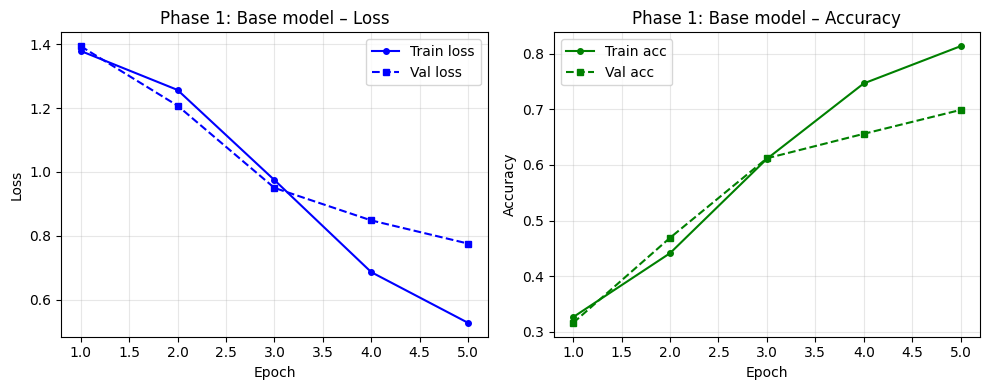

In [148]:
base_model = StandardTuningModel(
    vocab_size=vocab_size,
    num_classes=config["num_classes"],
    embed_dim=config["embed_dim"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    max_seq_length=config["max_seq_length"],
)

trainable_params, frozen_params = count_trainable_and_frozen_params(base_model)
print(
    f"Base model: Total: {trainable_params + frozen_params:,}, Trainable: {trainable_params:,}, Frozen: {frozen_params:,}"
)

_ = train(
    model=base_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=config["base_epochs"],
    learning_rate=config["base_lr"],
    device=device,
    trainable_params=None,
    plot=True,
    plot_title="Phase 1: Base model",
)

## Phase 2: Freeze base model and train p-tuning prompts

Base model: Total: 24, Trainable: 5, Frozen: 19
Epoch 1/5 | Train Loss: 0.4350 | Train Acc: 0.8660 | Val Loss: 0.7862 | Val Acc: 0.6930
Epoch 2/5 | Train Loss: 0.4219 | Train Acc: 0.8740 | Val Loss: 0.7791 | Val Acc: 0.7030
Epoch 3/5 | Train Loss: 0.4196 | Train Acc: 0.8733 | Val Loss: 0.7731 | Val Acc: 0.6980
Epoch 4/5 | Train Loss: 0.4163 | Train Acc: 0.8720 | Val Loss: 0.7749 | Val Acc: 0.6990
Epoch 5/5 | Train Loss: 0.4135 | Train Acc: 0.8723 | Val Loss: 0.7734 | Val Acc: 0.7040


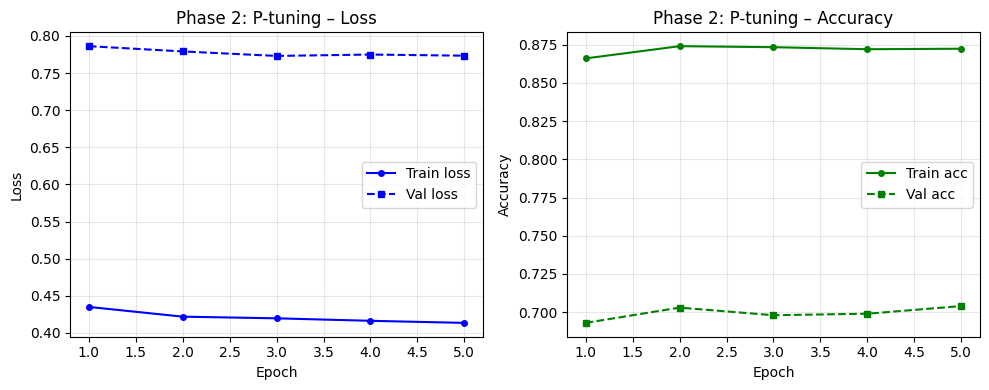

In [151]:
freeze_model_weights(base_model)

ptuning_model = create_ptuning_model(
    base_model,
    num_prompt_tokens=config["num_prompt_tokens"],
    mlp_hidden_dim=config["mlp_hidden_dim"],
)

trainable_params, frozen_params = count_trainable_and_frozen_params(ptuning_model)
print(
    f"Base model: Total: {trainable_params + frozen_params:,}, Trainable: {trainable_params:,}, Frozen: {frozen_params:,}"
)


trainable_params = ptuning_model.get_trainable_params()
_ = train(
    model=ptuning_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=config["ptuning_epochs"],
    learning_rate=config["ptuning_lr"],
    device=device,
    trainable_params=trainable_params,
    plot=True,
    plot_title="Phase 2: P-tuning",
)

## Evaluation on test set

In [150]:
criterion = nn.CrossEntropyLoss()
base_test_loss, base_test_acc = evaluate(base_model, test_loader, criterion, device)
ptuning_test_loss, ptuning_test_acc = evaluate(
    ptuning_model, test_loader, criterion, device
)

print(
    f"Base model    – Test loss: {base_test_loss:.4f}, Test accuracy: {base_test_acc:.4f}"
)
print(
    f"P-tuning model – Test loss: {ptuning_test_loss:.4f}, Test accuracy: {ptuning_test_acc:.4f}"
)

Base model    – Test loss: 0.9574, Test accuracy: 0.6440
P-tuning model – Test loss: 0.9287, Test accuracy: 0.6400
